<a href="https://colab.research.google.com/github/Bovi-analytics/Salamone-et-al-2025/blob/main/LyingTime_DaysInMilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for lying time DaysInMilk

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
.packages <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",
                  "tibble",
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car",
                  "stringr",
                  "cAIC4",
                  "ggrepel",
                  "geomtextpath",
                  "grid",
                  "sandwich",
                  "clubSandwich",
                  "skimr",
                  "purrr",
                  'cowplot',
                  "ggpubr"
                  )
# Install CRAN packages (if not already installed)
.inst <- .packages %in% installed.packages(lib.loc=lib_loc)
if(length(.packages[!.inst]) > 0) install.packages(.packages[!.inst], lib=lib_loc, repos = "http://cran.us.r-project.org")

# Load packages into session
lapply(.packages, require, character.only=TRUE, lib.loc = lib_loc, quietly = TRUE)



Attaching package: ‘dplyr’



    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



    filter, lag



    intersect, setdiff, setequal, union


Attaching package: ‘Matrix’



    expand, pack, unpack


Attaching package: ‘lmerTest’



    lmer



    step


Attaching package: ‘MASS’



    select


Attaching package: ‘TH.data’



    geyser


Caution: You lose important information if you filter this package's results.
See '? untidy'

Users are encouraged to switch the rest of the way.
See help('transition') for more information, including how to
convert old 'lsmeans' objects and scripts to work with 'emmeans'.

Attaching package: ‘car’



    recode


Attaching package: ‘nlme’



    lmList



    collapse


  method    from    
  bread.mlm sandwich

Attaching package: ‘purrr’



    some



    compact


Attaching package: ‘ggpubr’



    get_legend



    mutate




[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

[[23]]
[1] TRUE

[[24]]
[1] TRUE

[[25]]
[1] TRUE

[[26]]
[1] TRUE

[[27]]
[1] TRUE



## Data loading into dataframe

In [ ]:
%%R
MrtData <-
  readr::read_csv(
      "/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/NextMilkPredictions.csv",
      col_types = readr::cols(
          HerdId = readr::col_character(),
          AnimalId = readr::col_character()
          )
   ) %>%
  dplyr::filter(AmountMPRNext > 0.0) %>%
  dplyr::filter(DimMPRNext < 45) %>%
  dplyr::filter(DimMPRNext > 5) %>%
  dplyr::mutate(
      AnimalIdentifier = factor(AnimalId),
      CalvingDate = CalvingDateNext,
      MRT = AmountMPRNext - prediction,
      LactationNumber = lactationNumber + 1,
      HerdIdentifier = factor(case_when(
          HerdId == "287359"  ~ "3",
          HerdId == "269621" ~ "2746",
          HerdId == "6177195" ~ "2514",
          HerdId == "410638" ~ "3314",
          HerdId == "2209799" ~ "544",
          HerdId == "196062" ~ "700",
          HerdId == "325565" ~ "2011",
          HerdId == "207456" ~ "2297",
          TRUE ~  "UnknownUBN"
      ))) %>%
      group_by(HerdId) %>%
      mutate( MRTQuantile = case_when(
          MRT < quantile(MRT, probs= 0.33) ~ "LOW MRT",
          MRT <= quantile(MRT, probs= 0.66) ~ "MED MRT",
          MRT > quantile(MRT, probs= 0.66) ~ "HIGH MRT",
          TRUE ~"Missing")
      ) %>%  ungroup() %>%
  dplyr::select(
      "AnimalIdentifier",
      "HerdIdentifier",
      #"LactationNumber",
      "CalvingDate",
      "MRT",
      "MRTQuantile",
      "AmountMPRNext"
  )

In [ ]:
%%R
BehaviorData <-
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAndCalvingDataRepartitioned08032021/ObservationType=LyingTimeMinutesPerDay/part-00000-tid-3815821870089910923-ec384d9a-727d-46aa-970e-588ecba307c7-410-26.c000.csv",
    col_types = readr::cols(HerdIdentifier = readr::col_character(),
        TransitionLactationNumber = readr::col_integer(),
        TransitionParity = readr::col_character(),
        TransitionMonthsInMilk = readr::col_integer(),
        TransitionDaysInMilk = readr::col_integer(),
        TransitionCalvingDate = readr::col_character(),
        ##Hour = readr::col_integer(),
        Observations = readr::col_integer())) %>%
  dplyr::filter(dplyr::between(TransitionDaysInMilk, -21, 21)) %>%
  dplyr::filter(TransitionDaysInMilk != 0 )%>%
  dplyr:: filter(dplyr::between(ObservationValue,0,1500))%>%
  dplyr::mutate(
    CalvingDate = as.Date(TransitionCalvingDate),
    AnimalIdentifier = factor(str_replace_all(TransitionAnimalEartag, "[^0-9.]", "")),
    HerdIdentifier = factor(HerdIdentifier),
    LactationIdentifier = factor(paste(AnimalIdentifier,CalvingDate,sep="-")),
    Parity = factor(TransitionParity),
    LactationNumber = factor(TransitionLactationNumber),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    DaysInMilk = factor (TransitionDaysInMilk),
    numMonthsInMilk = TransitionMonthsInMilk,
    numDaysInMilk = TransitionDaysInMilk,
    CalvingSeason = factor(TransitionSeason),
    ##Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS")),
    CalvingGroup = factor(case_when(
          TransitionDaysInMilk <= -1 ~ "PreCalving",
          TransitionDaysInMilk >= 1 ~ "PostCalving",
          TRUE ~ "Missing"))) %>%
dplyr::select(
      AnimalIdentifier,
      HerdIdentifier,
      LactationIdentifier,
      Parity,
      MonthsInMilk,
      DaysInMilk,
      CalvingGroup,
      numMonthsInMilk,
      numDaysInMilk,
      CalvingSeason,
      CalvingDate,
      ##Hour,
      SensorValue,
      MilkingType,
      LactationNumber
      ) %>%
  tidyr::drop_na()

In [ ]:
%%R
AnalysisData <- BehaviorData %>%
  dplyr::inner_join(
      MrtData,
      by = c("HerdIdentifier", "AnimalIdentifier", "CalvingDate")
  )

In [ ]:
%%R
AnalysisData %>%
group_by(CalvingGroup)%>%
dplyr::summarise(Mean=mean(SensorValue, na.RM=TRUE), sd=sd(SensorValue))

# A tibble: 2 × 3
  CalvingGroup  Mean    sd
  <fct>        <dbl> <dbl>
1 PostCalving   630.  161.
2 PreCalving    777.  165.


In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 × 16
  AnimalIdentifier HerdIdentifier LactationIdentifier  Parity MonthsInMilk
  <fct>            <fct>          <fct>                <fct>  <fct>       
1 923683065        2011           923683065-2016-09-24 3+     0           
2 923683065        2011           923683065-2016-09-24 3+     0           
3 923683065        2011           923683065-2016-09-24 3+     0           
4 923683065        2011           923683065-2016-09-24 3+     0           
5 923683065        2011           923683065-2016-09-24 3+     1           
6 923683065        2011           923683065-2016-09-24 3+     1           
# ℹ 11 more variables: DaysInMilk <fct>, numMonthsInMilk <int>,
#   numDaysInMilk <int>, CalvingSeason <fct>, CalvingDate <dttm>,
#   SensorValue <dbl>, MilkingType <fct>, LactationNumber <fct>, MRT <dbl>,
#   MRTQuantile <chr>, AmountMPRNext <dbl>


In [ ]:
%%R
AnalysisData$MRTQuantile = factor(AnalysisData$MRTQuantile)
AnalysisData$MRTQuantile = relevel(AnalysisData$MRTQuantile,ref = "LOW MRT")

In [ ]:
%%R
str(AnalysisData)

tibble [87,465 × 16] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier   : Factor w/ 2525 levels "10464100825",..: 1687 1687 1687 1687 1687 1687 1687 845 845 845 ...
 $ HerdIdentifier     : Factor w/ 9 levels "2011","2297",..: 1 1 1 1 1 1 1 4 4 4 ...
 $ LactationIdentifier: Factor w/ 4278 levels "10464100825-2017-01-13",..: 3463 3463 3463 3463 3463 3463 3463 1581 1581 1581 ...
 $ Parity             : Factor w/ 3 levels "1","2","3+": 3 3 3 3 3 3 3 2 2 2 ...
 $ MonthsInMilk       : Factor w/ 2 levels "0","1": 1 1 1 1 2 2 2 1 1 1 ...
 $ DaysInMilk         : Factor w/ 42 levels "-21","-20","-19",..: 1 11 14 20 28 35 37 1 2 5 ...
 $ numMonthsInMilk    : int [1:87465] 0 0 0 0 1 1 1 0 0 0 ...
 $ numDaysInMilk      : int [1:87465] -21 -11 -8 -2 7 14 16 -21 -20 -17 ...
 $ CalvingSeason      : Factor w/ 4 levels "Autumn","Spring",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ CalvingDate        : POSIXct[1:87465], format: "2016-09-24" "2016-09-24" ...
 $ SensorValue        : num [1:87465] 737 821 740 721 534 625 

## Descriptive statistics

In [ ]:
%%R
# Total Lactation Per Parity
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier, CalvingDate))

# A tibble: 2 × 2
  Parity Unique_Elements
  <fct>            <int>
1 2                  756
2 3+                1625


In [ ]:
%%R
# Total Number Animals
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 × 1
  Unique_Elements
            <int>
1            1361


In [ ]:
%%R
# Number of Animals per Lactation
AnalysisData %>%
  group_by(LactationNumber) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier, CalvingDate, Parity))

# A tibble: 10 × 2
   LactationNumber Unique_Elements
   <fct>                     <int>
 1 2                           756
 2 3                           641
 3 4                           449
 4 5                           274
 5 6                           151
 6 7                            57
 7 8                            30
 8 9                            14
 9 10                            9
10 11                            1


# Model building

##Multivariable Models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~
                  Parity + DaysInMilk + CalvingSeason + HerdIdentifier +  MRTQuantile +
                  (1 + numDaysInMilk|LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + 
    MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
               npar     AIC     LRT   Pr(Chi)    
<none>              1083962                      
Parity            1 1083961     0.1    0.7184    
DaysInMilk       41 1094619 10738.3 < 2.2e-16 ***
CalvingSeason     3 1084023    66.2 2.813e-14 ***
HerdIdentifier    6 1084278   328.0 < 2.2e-16 ***
MRTQuantile       2 1083959     0.3    0.8772    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with DaysInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~
                  DaysInMilk*Parity + CalvingSeason + HerdIdentifier + MRTQuantile +
                  (1 + numDaysInMilk| LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
Model2.1: SensorValue ~ DaysInMilk * Parity + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
         npar     AIC     BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   58 1083962 1084506 -541923  1083846                         
Model2.1   99 1083951 1084880 -541877  1083753 93.229 41  6.082e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~
                  DaysInMilk*HerdIdentifier + CalvingSeason + Parity + MRTQuantile +
                  (1 + numDaysInMilk| LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
Model2.2: SensorValue ~ DaysInMilk * HerdIdentifier + CalvingSeason + Parity + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
         npar     AIC     BIC  logLik deviance  Chisq  Df Pr(>Chisq)    
Model2.0   58 1083962 1084506 -541923  1083846                          
Model2.2  304 1082390 1085241 -540891  1081782 2064.2 246  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~
                  DaysInMilk*CalvingSeason + Parity + HerdIdentifier + MRTQuantile +
                  (1 + numDaysInMilk| LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
Model2.3: SensorValue ~ DaysInMilk * CalvingSeason + Parity + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
         npar     AIC     BIC  logLik deviance  Chisq  Df Pr(>Chisq)    
Model2.0   58 1083962 1084506 -541923  1083846                          
Model2.3  181 1083858 1085556 -541748  1083496 349.97 123  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~
                  DaysInMilk*MRTQuantile + Parity + HerdIdentifier + CalvingSeason +
                  (1 + numDaysInMilk| LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
Model2.4: SensorValue ~ DaysInMilk * MRTQuantile + Parity + HerdIdentifier + CalvingSeason + (1 + numDaysInMilk | LactationIdentifier)
         npar     AIC     BIC  logLik deviance  Chisq Df Pr(>Chisq)  
Model2.0   58 1083962 1084506 -541923  1083846                       
Model2.4  140 1084018 1085331 -541869  1083738 108.04 82    0.02858 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~
                  DaysInMilk*CalvingSeason +
                  DaysInMilk*Parity +
                  DaysInMilk*MRTQuantile +
                  DaysInMilk*HerdIdentifier +
                  (1 + numDaysInMilk|LactationIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + DaysInMilk + CalvingSeason + HerdIdentifier + MRTQuantile + (1 + numDaysInMilk | LactationIdentifier)
Model2.5: SensorValue ~ DaysInMilk * CalvingSeason + DaysInMilk * Parity + DaysInMilk * MRTQuantile + DaysInMilk * HerdIdentifier + (1 + numDaysInMilk | LactationIdentifier)
         npar     AIC     BIC  logLik deviance  Chisq  Df Pr(>Chisq)    
Model2.0   58 1083962 1084506 -541923  1083846                          
Model2.5  550 1082320 1087478 -540610  1081220 2626.7 492  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
finalModel <- Model2.5
Modeldrop <- drop1(finalModel, test="Chisq")
if("Pr(>F)" %in% colnames(Modeldrop))
{
  Pvalues <- Modeldrop$`Pr(>F)`
} else
{
  Pvalues <- Modeldrop$`Pr(Chi)`
}
Modeldrop

Single term deletions

Model:
SensorValue ~ DaysInMilk * CalvingSeason + DaysInMilk * Parity + 
    DaysInMilk * MRTQuantile + DaysInMilk * HerdIdentifier + 
    (1 + numDaysInMilk | LactationIdentifier)
                          npar     AIC     LRT   Pr(Chi)    
<none>                         1082320                      
DaysInMilk:CalvingSeason   123 1082417  343.46 < 2.2e-16 ***
DaysInMilk:Parity           41 1082341  103.50 2.577e-07 ***
DaysInMilk:MRTQuantile      82 1082274  118.09  0.005595 ** 
DaysInMilk:HerdIdentifier  246 1083906 2078.69 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/Models/finalmodelLyingtimeDaysInMilk.rdata")

In [ ]:
%%R
load(file="/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/Models/finalmodelLyingtimeDaysInMilk.rdata")

# Final model analysis of variance

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                               Chisq  Df Pr(>Chisq)    
DaysInMilk                12546.0886  41  < 2.2e-16 ***
CalvingSeason                68.1438   3  1.066e-14 ***
Parity                        0.1715   1   0.678786    
MRTQuantile                   0.2505   2   0.882259    
HerdIdentifier              354.4000   6  < 2.2e-16 ***
DaysInMilk:CalvingSeason    345.4101 123  < 2.2e-16 ***
DaysInMilk:Parity           102.5774  41  3.454e-07 ***
DaysInMilk:MRTQuantile      118.2363  82   0.005451 ** 
DaysInMilk:HerdIdentifier  2100.9381 246  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model figures and LSM (95% CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ DaysInMilk), alpha=0.05, Letters=letters, adjust="sidak")

To enable adjustments, add the argument 'pbkrtest.limit = 87465' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 87465)' or larger];
but be warned that this may result in large computation time and memory use.

To enable adjustments, add the argument 'lmerTest.limit = 87465' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 87465)' or larger];
but be warned that this may result in large computation time and memory use.




 DaysInMilk lsmean   SE  df asymp.LCL asymp.UCL .group         
 1             606 3.73 Inf       594       618  a             
 20            614 4.42 Inf       600       628  ab            
 21            615 4.48 Inf       601       630  abc           
 19            617 4.37 Inf       603       631  abc           
 18            619 4.32 Inf       605       633  abc           
 2             621 3.74 Inf       609       634  abcd          
 14            622 4.11 Inf       608       635  abcd          
 17            622 4.26 Inf       608       636  abcd          
 16            623 4.21 Inf       609       636  abcd          
 13            625 4.07 Inf       611       638   bcde         
 15            625 4.16 Inf       611       638   bcde         
 11            626 3.99 Inf       613       639   bcde         
 12            627 4.03 Inf       614       640   bcde         
 9             627 3.91 Inf       615       640   bcde         
 10            631 3.95 Inf       618   

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="sidak")

To enable adjustments, add the argument 'pbkrtest.limit = 87465' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 87465)' or larger];
but be warned that this may result in large computation time and memory use.

To enable adjustments, add the argument 'lmerTest.limit = 87465' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 87465)' or larger];
but be warned that this may result in large computation time and memory use.




 Parity lsmean   SE  df asymp.LCL asymp.UCL .group
 3+        699 2.83 Inf       693       705  a    
 2         701 4.01 Inf       692       710  a    

Results are averaged over the levels of: DaysInMilk, CalvingSeason, MRTQuantile, HerdIdentifier 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 2 estimates 
significance level used: alpha = 0.05 
NOTE: If two or more means share the same grouping symbol,
      then we cannot show them to be different.
      But we also did not show them to be the same. 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="sidak")

To enable adjustments, add the argument 'pbkrtest.limit = 87465' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 87465)' or larger];
but be warned that this may result in large computation time and memory use.

To enable adjustments, add the argument 'lmerTest.limit = 87465' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 87465)' or larger];
but be warned that this may result in large computation time and memory use.




 CalvingSeason lsmean   SE  df asymp.LCL asymp.UCL .group
 Summer           685 4.25 Inf       674       695  a    
 Autumn           686 4.26 Inf       675       696  a    
 Spring           713 5.22 Inf       700       726   b   
 Winter           718 4.88 Inf       706       730   b   

Results are averaged over the levels of: DaysInMilk, Parity, MRTQuantile, HerdIdentifier 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: sidak method for 6 tests 
significance level used: alpha = 0.05 
NOTE: If two or more means share the same grouping symbol,
      then we cannot show them to be different.
      But we also did not show them to be the same. 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MRTQuantile), alpha=0.05, Letters=letters, adjust="sidak")

To enable adjustments, add the argument 'pbkrtest.limit = 87465' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 87465)' or larger];
but be warned that this may result in large computation time and memory use.

To enable adjustments, add the argument 'lmerTest.limit = 87465' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 87465)' or larger];
but be warned that this may result in large computation time and memory use.




 MRTQuantile lsmean   SE  df asymp.LCL asymp.UCL .group
 HIGH MRT       698 4.02 Inf       688       708  a    
 LOW MRT        701 3.98 Inf       692       711  a    
 MED MRT        702 4.11 Inf       692       712  a    

Results are averaged over the levels of: DaysInMilk, CalvingSeason, Parity, HerdIdentifier 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: sidak method for 3 tests 
significance level used: alpha = 0.05 
NOTE: If two or more means share the same grouping symbol,
      then we cannot show them to be different.
      But we also did not show them to be the same. 


## Interactions

### DaysInMilk by MRTQuantile

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MRTQuantile|DaysInMilk, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="sidak")


To enable adjustments, add the argument 'pbkrtest.limit = 87465' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 87465)' or larger];
but be warned that this may result in large computation time and memory use.

To enable adjustments, add the argument 'lmerTest.limit = 87465' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 87465)' or larger];
but be warned that this may result in large computation time and memory use.



DaysInMilk = -21:
 MRTQuantile emmean   SE  df asymp.LCL asymp.UCL .group
 LOW MRT        755 6.43 Inf       740       770  a    
 MED MRT        762 6.64 Inf       746       777  a    
 HIGH MRT       769 6.49 Inf       753       784  a    

DaysInMilk = -20:
 MRTQuantile emmean   SE  df asymp.LCL asymp.UCL .group
 LOW MRT        753 6.35 Inf       738       768  a    
 MED MRT        763 6.55 Inf       747       778  a    
 HIGH MRT       766 6.41 Inf       751       781  a    

DaysInMilk = -19:
 MRTQuantile emmean   SE  df asymp.LCL asymp.UCL .group
 LOW MRT        755 6.28 Inf       740       770  a    
 MED MRT        756 6.48 Inf       741       772  a    
 HIGH MRT       774 6.34 Inf       759       789  a    

DaysInMilk = -18:
 MRTQuantile emmean   SE  df asymp.LCL asymp.UCL .group
 LOW MRT        761 6.20 Inf       746       776  a    
 MED MRT        768 6.40 Inf       753       783  a    
 HIGH MRT       773 6.27 Inf       758       788  a    

DaysInMilk = -17:
 MRTQuanti

In [ ]:
%%R
confint(LSMs$contrasts)

DaysInMilk = -21:
 contrast            estimate   SE  df asymp.LCL asymp.UCL
 LOW MRT - HIGH MRT -13.50169 8.79 Inf   -34.092     7.089
 LOW MRT - MED MRT   -6.39705 8.83 Inf   -27.101    14.307
 HIGH MRT - MED MRT   7.10465 8.96 Inf   -13.884    28.094

DaysInMilk = -20:
 contrast            estimate   SE  df asymp.LCL asymp.UCL
 LOW MRT - HIGH MRT -12.96360 8.67 Inf   -33.285     7.358
 LOW MRT - MED MRT  -10.01099 8.72 Inf   -30.451    10.429
 HIGH MRT - MED MRT   2.95261 8.84 Inf   -17.760    23.665

DaysInMilk = -19:
 contrast            estimate   SE  df asymp.LCL asymp.UCL
 LOW MRT - HIGH MRT -19.63001 8.58 Inf   -39.732     0.472
 LOW MRT - MED MRT   -1.81018 8.62 Inf   -22.023    18.403
 HIGH MRT - MED MRT  17.81983 8.74 Inf    -2.663    38.303

DaysInMilk = -18:
 contrast            estimate   SE  df asymp.LCL asymp.UCL
 LOW MRT - HIGH MRT -11.55932 8.48 Inf   -31.434     8.315
 LOW MRT - MED MRT   -7.12637 8.52 Inf   -27.093    12.840
 HIGH MRT - MED MRT   4.43296 8.64 Inf  

Effect Size

In [ ]:
%%R
emm <- emmeans(
        finalModel,
        ~ MRTQuantile|DaysInMilk,
        lmer.df = "asymptotic",
        lmerTest.limit = 11848
        )

effSizes <- eff_size(emm, sigma = sigma(finalModel), edf = Inf) %>% as.data.frame()



In [ ]:
%%R
pairs(emm, main = "LOW MRT")

DaysInMilk = -21:
 contrast            estimate   SE  df z.ratio p.value
 LOW MRT - HIGH MRT -13.50169 8.79 Inf  -1.537  0.2737
 LOW MRT - MED MRT   -6.39705 8.83 Inf  -0.724  0.7492
 HIGH MRT - MED MRT   7.10465 8.96 Inf   0.793  0.7071

DaysInMilk = -20:
 contrast            estimate   SE  df z.ratio p.value
 LOW MRT - HIGH MRT -12.96360 8.67 Inf  -1.495  0.2932
 LOW MRT - MED MRT  -10.01099 8.72 Inf  -1.148  0.4846
 HIGH MRT - MED MRT   2.95261 8.84 Inf   0.334  0.9403

DaysInMilk = -19:
 contrast            estimate   SE  df z.ratio p.value
 LOW MRT - HIGH MRT -19.63001 8.58 Inf  -2.289  0.0574
 LOW MRT - MED MRT   -1.81018 8.62 Inf  -0.210  0.9760
 HIGH MRT - MED MRT  17.81983 8.74 Inf   2.039  0.1030

DaysInMilk = -18:
 contrast            estimate   SE  df z.ratio p.value
 LOW MRT - HIGH MRT -11.55932 8.48 Inf  -1.363  0.3604
 LOW MRT - MED MRT   -7.12637 8.52 Inf  -0.837  0.6803
 HIGH MRT - MED MRT   4.43296 8.64 Inf   0.513  0.8649

DaysInMilk = -17:
 contrast            estim

In [ ]:
%%R
dfConfInts <- confint(pairs(emm,main = "LOW MRT"), method = "Wald") %>%
  as.data.frame() %>%
  mutate(contrast = as.character(contrast),
        label = if_else(DaysInMilk == max(as.numeric(DaysInMilk)), as.character(contrast), NA_character_),
         significance = as.factor(case_when(
             asymp.LCL <= 0 & asymp.UCL <= 0 ~ "Significant",
             asymp.LCL >= 0 & asymp.UCL >= 0 ~ "Significant",
             TRUE ~ "Not-Significant")),
         contrast = as.factor(case_when(
             contrast == "LOW MRT - HIGH MRT" ~ "LOW - HIGH",
             contrast == "LOW MRT - MED MRT" ~ "LOW - MED",
             contrast == "HIGH MRT - MED MRT" ~ "HIGH - MED",
             TRUE ~ "Error"))
         )


In [ ]:
%%R
Significance = dfConfInts %>%pivot_wider(id_cols = DaysInMilk, names_from = contrast, values_from = significance)
Significance

# A tibble: 42 × 4
   DaysInMilk `LOW - HIGH`    `LOW - MED`     `HIGH - MED`   
   <fct>      <fct>           <fct>           <fct>          
 1 -21        Not-Significant Not-Significant Not-Significant
 2 -20        Not-Significant Not-Significant Not-Significant
 3 -19        Not-Significant Not-Significant Not-Significant
 4 -18        Not-Significant Not-Significant Not-Significant
 5 -17        Not-Significant Not-Significant Not-Significant
 6 -16        Significant     Not-Significant Not-Significant
 7 -15        Not-Significant Not-Significant Not-Significant
 8 -14        Not-Significant Not-Significant Not-Significant
 9 -13        Not-Significant Not-Significant Not-Significant
10 -12        Significant     Significant     Not-Significant
# ℹ 32 more rows
# ℹ Use `print(n = ...)` to see more rows


Visualizations

In [ ]:
%%R

group.colors<-c("LOW MRT"="#FF0090", "HIGH MRT"="#ffa500", "MED MRT"="#3891A6","Significant"="#655e5c")
dfLMSs <- multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="sidak")

myLoc <-
  (which(levels(dfLMSs$DaysInMilk) == "-1") +
     which(levels(dfLMSs$DaysInMilk) == "1")) /
  2


Joining with `by = join_by(DaysInMilk)`


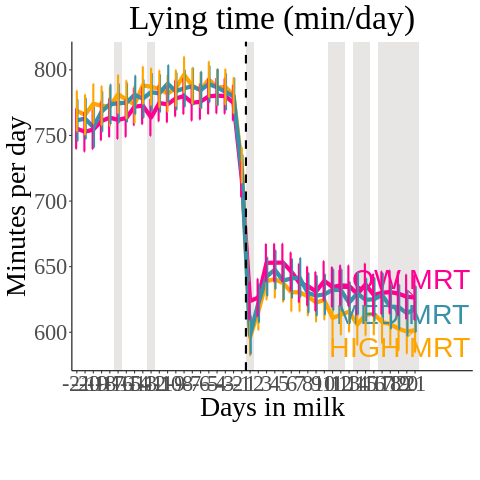

In [ ]:
%%R

p = dfLMSs %>% inner_join(Significance) %>%  mutate(label = if_else(DaysInMilk == max(as.numeric(DaysInMilk)), as.character(MRTQuantile), NA_character_),
                                                    significance = case_when(
                                                        `LOW - HIGH` == "Significant" ~ "Significant",
                                                        `LOW - MED` == "Significant" ~ "Significant",
                                                        `HIGH - MED` == "Significant" ~ "Significant",
                                                        TRUE ~ "Not-Significant"
                                                    )) %>%
  ggplot(
  aes(
    x=DaysInMilk,
    y=emmean,
    group=MRTQuantile,
    color=MRTQuantile)
    ) +
    scale_color_manual(values=group.colors)+
    scale_fill_manual(values=group.colors)+
    scale_alpha_manual(values = c("Not-Significant"=0,"Significant"=0.05))+ # transparency significance rectangles
    geom_rect(aes(xmin=as.numeric(DaysInMilk)-0.5, xmax =as.numeric(DaysInMilk)+0.5,ymin=-Inf,ymax=Inf,fill =significance ,alpha = significance),color = NA )+
    geom_line(size=2) +
    geom_text_repel(data= subset(dfLMSs,DaysInMilk == 21), aes(label = MRTQuantile, colour = MRTQuantile, x = 42, y= emmean),hjust = -0.8, size = 10, nudge_x =7,box.padding = 0.5,direction = "y")+
    geom_errorbar(
    aes(ymin=asymp.LCL,
        ymax=asymp.UCL),
    width=0.25,
    size=1,
    position=position_dodge(0.25)) +
  labs(
    title = "Lying time (min/day)",
    y="Minutes per day" ,
    x = "Days in milk") +
  theme_bw() +
  theme(text = element_text(family = "Times New Roman"),plot.margin = unit(c(0.5,0.5,4,0.5), "lines")) +
  theme(text=element_text(size=28),
        plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black"))+
  theme (legend.position= "none")+
  geom_vline(xintercept = myLoc, size = 1, linetype= "dashed", color ="black")



gt <- ggplotGrob(p)
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)



In [ ]:
%%R
ggsave(plot = gt, "/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/Figures/LyingTimeMRTQuantileByDaysInMilk.png", width = 24, height = 8)

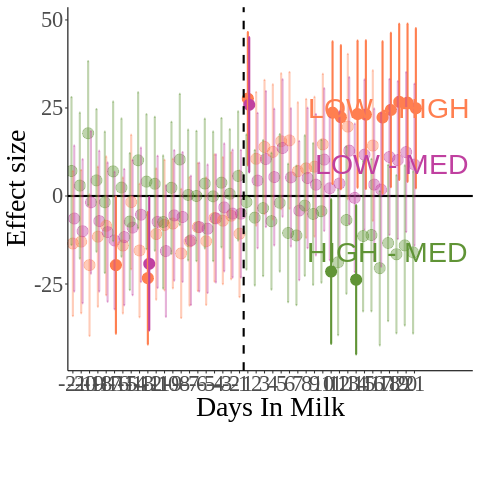

In [ ]:
%%R

myLoc <-
  (which(levels(dfLMSs$DaysInMilk) == "-1") +
     which(levels(dfLMSs$DaysInMilk) == "1")) /
  2

group.colors<-c("HIGH - MED"="#609436", "LOW - MED"="#C040A0", "LOW - HIGH"="#FF7F50","Significant"="#171710")
plotEffectSize <- dfConfInts %>%
  ggplot(
  aes(
    x=DaysInMilk,
    y=estimate,color = contrast)
    ) +
    scale_color_manual(values = group.colors)+
    scale_fill_manual(values = group.colors)+
  geom_hline(yintercept=0, color= "black", size=1) +
  scale_alpha_manual(values = c("Not-Significant"=0.4,"Significant"=1))+ # transparency significance each group
  geom_point(aes(alpha = significance),size=5,position=position_dodge(0.5)) +
  geom_errorbar(
    aes(ymin=asymp.LCL,
        ymax=asymp.UCL,
        alpha = significance),
    position=position_dodge(0.5),
    width=0.5,
    size=1) +
  geom_text_repel(data= subset(dfConfInts,DaysInMilk == 21), aes(label = contrast, colour = contrast, x = 42, y= estimate),hjust = -0.8, size = 10, nudge_x =7,box.padding = 0.5,direction = "y") +
  labs(
    y="Effect size" ,
    x = "Days In Milk") +
  theme_bw() +
  theme(text = element_text(family = "Times New Roman",size =28),
        plot.title = element_blank(),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black"),
        legend.position="none",
        legend.title = element_blank(),
        plot.margin = unit(c(0.5,0.5,4,0.5), "lines"))+
  geom_vline(xintercept = myLoc, size = 1, linetype= "dashed", color ="black")

plotEffectSize

In [ ]:
%%R
ggsave(plot = plotEffectSize,"/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/Figures/LyingTimeMRTQuantileByDaysInMilkeffectPlot.png", width = 24, height = 6)

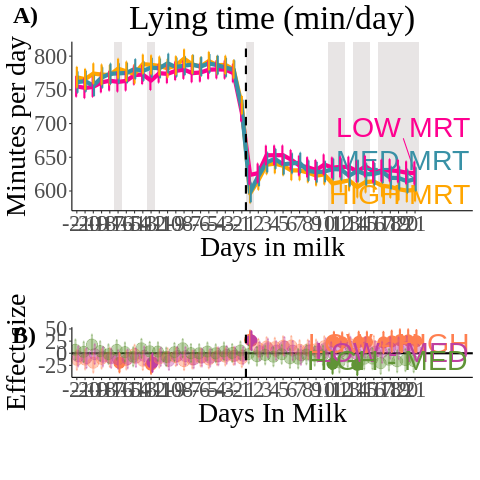

In [ ]:
%%R
combinedPlot <- ggarrange(
    gt,
    plotEffectSize,
    heights = c(2, 1),
    labels = c("A)","B)"),
    ncol = 1,
    nrow = 2,
    align ="v",font.label=list(family = "Times New Roman",size=24))


    combinedPlot

In [ ]:
%%R
ggsave(plot = combinedPlot,"/content/drive/Shareddrives/Bovi-Analytics/Projects/CelienKemel/Figures/LyingTimeMRTQuantileByDaysInMilkCombo.png", width = 24, height = 14)